<a href="https://colab.research.google.com/github/brenosyperrek/ufsc_dc_exercicios/blob/main/Dados_Espaciais_e_Temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Curso - Introdução a Ciência de Dados (PROEX, UFSC) 
###Professores:  Jônata Tyska, Mateus Grellert 
O conteúdo deste notebook está relacionado à videoaula intitulada **Dados Espaciais e Temporais**.

Iremos tratar de algumas técnicas clássicas de manipulação para estes tipos de dados, assim como discutir estratégias para torná-los retangulares.

# 1 - Dados Espaciais

Vamos começar com dados espaciais, em que a informação está associada a uma localização espacial (grade, plano cartesiano etc.).

As principais bibliotecas que usamos para processar imagens são <code>skimage</code> e <code>scipy.ndimage</code>.

---



## Filtragem

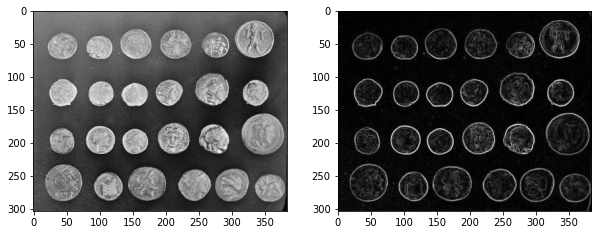

In [ ]:
from skimage import data, io, filters
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(1,2, figsize = (10,4))

image = data.coins() # imagem em preto e branco (somente um canal de luminância)
axes[0].imshow(image, cmap = 'gray')

edges = filters.sobel(image)  #aplicação do filtro de Sobel para destacar bordas nos objetos
axes[1].imshow(edges, cmap = 'gray')


## Downsampling



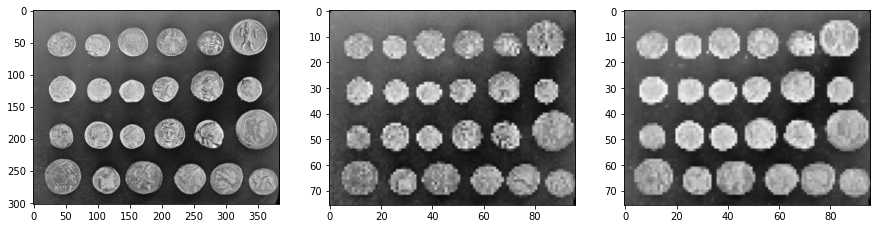

In [ ]:
from skimage.measure import block_reduce
import numpy as np 
from skimage import data, exposure

fig, axes = plt.subplots(1,3, figsize = (15,4))

image_downsampled = image[::4,::4] #downsample 4:1 nas linhas e colunas (tamanho reduzido por um fator 1/16)
image_maxpool = block_reduce(image, (4,4), np.max)

axes[0].imshow(image, cmap = 'gray')
axes[1].imshow(image_downsampled, cmap = 'gray')
axes[2].imshow(image_maxpool, cmap = 'gray')


## Histogram of Oriented Gradients (HOG)



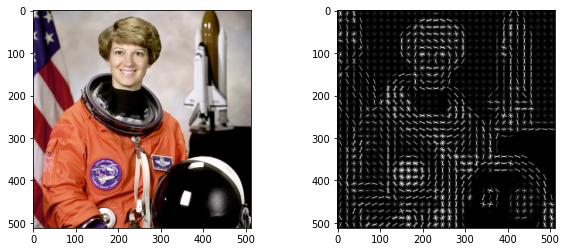

In [ ]:
from skimage.feature import hog
from skimage import data, exposure

fig, axes = plt.subplots(1,2, figsize = (10,4))

image = data.astronaut()

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0,10))
axes[0].imshow(image)
axes[1].imshow(hog_image_rescaled, cmap = 'gray')


## Remoção de ruído

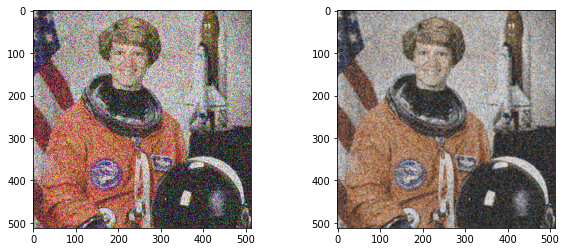

In [ ]:
from scipy.ndimage import gaussian_filter
from skimage import util

fig, axes = plt.subplots(1,2, figsize = (10,4))

image_noise = util.random_noise(image, mode='gaussian', mean=0, var=0.25)


image_denoise = gaussian_filter(image_noise, sigma=0.75)


axes[0].imshow(image_noise)
axes[1].imshow(image_denoise)



# 2 - Séries Temporais

Assim como imagens, séries temporais também possuem uma marcação de localização dos dados (nesse caso, um tipo de data/horário). Séries temporais usualmente precisam passar por algumas operações de preprocessamento para poderem ser analisadas ou aplicadas para modelagem preditiva.

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5


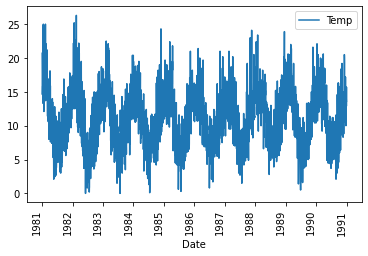

In [ ]:
import pandas as pd

# dados de temperatura mínima em NY entre 1971 e 1973
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url, parse_dates=True)
# convertendo data de string para o tipo especial datetime. Isso permite manipular melhor esse tipo de dado
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(['Date'],inplace=True)

df.plot(rot=90)
df

## Suavização com média móvel

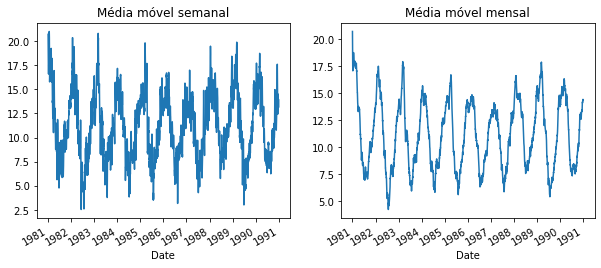

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (10,4))

df_week = df.rolling(window="7D").mean()
df_month = df.rolling(window="30D").mean()

df_week.plot(ax = axes[0], legend = '', title = 'Média móvel semanal')
df_month.plot(ax = axes[1], legend = '', title = 'Média móvel mensal')

## ACF e PACF plots

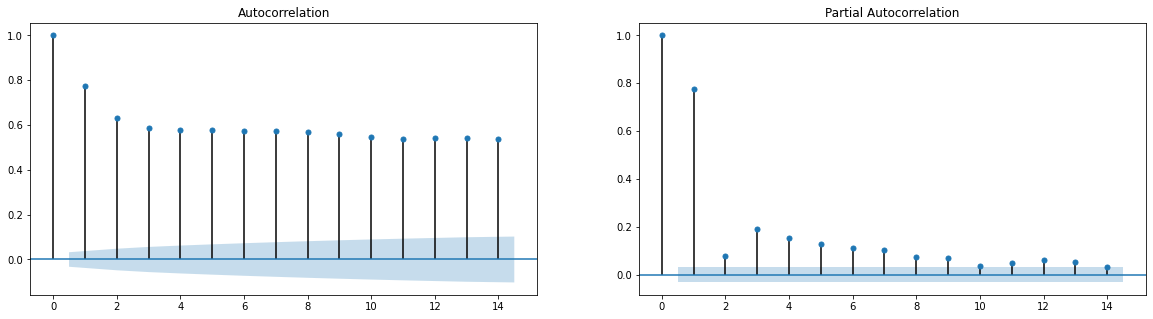

In [ ]:
import statsmodels.api as sm

fig, axes = plt.subplots(1,2, figsize = (15,5))

sm.graphics.tsa.plot_acf(df.values.squeeze(), lags=14, ax = axes[0])
sm.graphics.tsa.plot_pacf(df.values.squeeze(), lags=14, ax = axes[1])

plt.show()

# 3 - Tornando os dados retangulares

## Imagens

In [ ]:
from skimage import data, color
from sklearn.decomposition import PCA
from skimage import color

image = data.astronaut()
image_gray = color.rgb2gray(image)

pca = PCA(n_components = 20)
pca.fit(image_gray)


image_pca = pca.transform(image_gray)

print(f"Tamanho original: {image_gray.shape}\nTamanho PCA: {image_pca.shape}")



Tamanho original: (512, 512)
Tamanho PCA: (512, 20)


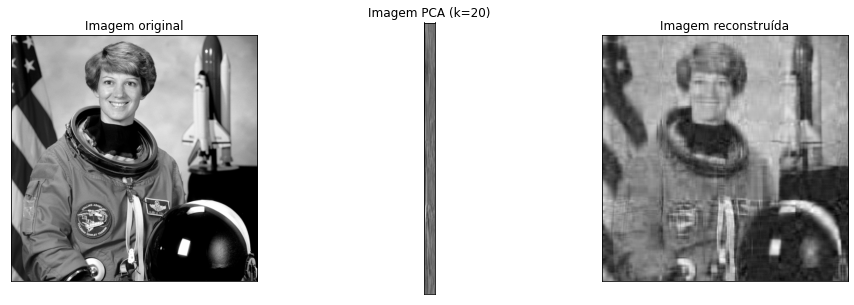

In [ ]:
fig, axes = plt.subplots(1,3, figsize = (15,5))
titles = ['Imagem original','Imagem PCA (k=20)','Imagem reconstruída']

image_recons = pca.inverse_transform(image_pca)

axes[0].imshow(image_gray, cmap = 'gray')
axes[1].imshow(image_pca, cmap = 'gray')
axes[2].imshow(image_recons, cmap = 'gray')

for ax, title in zip(axes, titles):
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.set_title(title)


## Séries temporais

In [ ]:
# vamos usar um método auxiliar para transformar uma série temporal em um conjunto de features (lags anteriores) 
# e de labels (passos adiante)
# fonte: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/


from pandas import DataFrame
from pandas import concat

# os parâmetros n_in e n_out controlam o número de features de entrada e de labels respectivamente
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:

# dados de temperatura mínima em NY entre 1971 e 1973
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url, parse_dates=True)
# convertendo data de string para o tipo especial datetime. Isso permite manipular melhor esse tipo de dado
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(['Date'],inplace=True)


In [ ]:
# criando um novo data set retangular considerando 3 passos pra trás
df_retangular = series_to_supervised(df, n_in = 3, n_out = 1)
df_retangular

,var1(t-3),var1(t-2),var1(t-1),var1(t)
Date,,,,
1981-01-04,20.7,17.9,18.8,14.6
1981-01-05,17.9,18.8,14.6,15.8
1981-01-06,18.8,14.6,15.8,15.8
1981-01-07,14.6,15.8,15.8,15.8
1981-01-08,15.8,15.8,15.8,17.4
...,...,...,...,...
1990-12-27,10.0,12.9,14.6,14.0
1990-12-28,12.9,14.6,14.0,13.6
1990-12-29,14.6,14.0,13.6,13.5
